In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn import preprocessing
from tqdm import tqdm

In [2]:
%matplotlib inline
mpl.matplotlib_fname()
mpl.rc_file_defaults()

In [3]:
#data_pd = pd.read_pickle("../data/credit_card_cleaned.pickle")[::100][["LIMIT_BAL", "PAY_1", "default payment next month"]]
#data = data_pd.to_numpy(); data_pd.describe()

In [4]:
#input_data = data[:,:-1]
#output_data = data[:,-1]
#nr_params = input_data.shape[1]
#nr_datapoints = input_data.shape[0]; nr_params, nr_datapoints

In [5]:
input_data = np.arange(0, 1000)
output_data = np.zeros_like(input_data,dtype=int)
output_data[500:] = 1
nr_datapoints = input_data.shape[0]; nr_datapoints

1000

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(input_data, output_data)
Scaler = preprocessing.StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train.reshape(-1,1))
X_test_scaled = Scaler.transform(X_test.reshape(-1,1))

In [7]:
X_test.shape

(250,)

In [8]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

class NeuralNetwork:
    def __init__(
            self,
            X_data,
            Y_data,
            n_hidden_neurons=50,
            n_categories=10,
            epochs=10,
            batch_size=100,
            eta=0.1,
            lmbd=0.0):

        self.X_data_full = X_data
        self.Y_data_full = Y_data

        self.n_inputs = X_data.shape[0]
        self.n_features = X_data.shape[1]
        self.n_hidden_neurons = n_hidden_neurons
        self.n_categories = n_categories

        self.epochs = epochs
        self.batch_size = batch_size
        self.iterations = self.n_inputs // self.batch_size
        self.eta = eta
        self.lmbd = lmbd

        self.create_biases_and_weights()
        
        # Accuracy score tracking
        self.accuracy_each_epoch_train = np.zeros(epochs)
        self.accuracy_each_epoch_test = np.zeros(epochs)
        

    def create_biases_and_weights(self):
        self.hidden_weights = np.random.randn(self.n_features, self.n_hidden_neurons)
        self.hidden_bias = np.zeros(self.n_hidden_neurons) + 0.01

        self.output_weights = np.random.randn(self.n_hidden_neurons, self.n_categories)
        self.output_bias = np.zeros(self.n_categories) + 0.01

    def feed_forward(self):
        # feed-forward for training
        self.z_h = np.matmul(self.X_data, self.hidden_weights) + self.hidden_bias
        self.a_h = sigmoid(self.z_h)

        self.z_o = np.matmul(self.a_h, self.output_weights) + self.output_bias

        exp_term = np.exp(self.z_o)
        self.probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)

    def feed_forward_out(self, X):
        # feed-forward for output
        z_h = np.matmul(X, self.hidden_weights) + self.hidden_bias
        a_h = sigmoid(z_h)

        z_o = np.matmul(a_h, self.output_weights) + self.output_bias
        
        exp_term = np.exp(z_o)
        probabilities = exp_term / np.sum(exp_term, axis=1, keepdims=True)
        return probabilities

    def backpropagation(self):
        error_output = self.probabilities - self.Y_data
        error_hidden = np.matmul(error_output, self.output_weights.T) * self.a_h * (1 - self.a_h)

        self.output_weights_gradient = np.matmul(self.a_h.T, error_output)
        self.output_bias_gradient = np.sum(error_output, axis=0)

        self.hidden_weights_gradient = np.matmul(self.X_data.T, error_hidden)
        self.hidden_bias_gradient = np.sum(error_hidden, axis=0)

        if self.lmbd > 0.0:
            self.output_weights_gradient += self.lmbd * self.output_weights
            self.hidden_weights_gradient += self.lmbd * self.hidden_weights

        self.output_weights -= self.eta * self.output_weights_gradient
        self.output_bias -= self.eta * self.output_bias_gradient
        self.hidden_weights -= self.eta * self.hidden_weights_gradient
        self.hidden_bias -= self.eta * self.hidden_bias_gradient

    def predict(self, X):
        probabilities = self.feed_forward_out(X)
        return np.argmax(probabilities, axis=1)

    def predict_probabilities(self, X):
        probabilities = self.feed_forward_out(X)
        return probabilities

    def train(self):
        data_indices = np.arange(self.n_inputs)

        for i in tqdm(range(self.epochs)):
            for j in range(self.iterations):
                # pick datapoints with replacement
                chosen_datapoints = np.random.choice(
                    data_indices, size=self.batch_size, replace=False
                )

                # minibatch training data
                self.X_data = self.X_data_full[chosen_datapoints]
                self.Y_data = self.Y_data_full[chosen_datapoints]

                self.feed_forward()
                self.backpropagation()
            self.accuracy_each_epoch_train[i] = self.accuracy_score(Y_train,self.predict(X_train_scaled))
            self.accuracy_each_epoch_test[i] = self.accuracy_score(Y_test,self.predict(X_test_scaled))
            
    def accuracy_score(self,Y_test, Y_pred):
        return np.sum(Y_test == Y_pred) / len(Y_test)

In [9]:
def accuracy_score(Y_test, Y_pred):
    return np.sum(Y_test == Y_pred) / len(Y_test)

In [15]:
nn = NeuralNetwork( X_train_scaled,
                    Y_train.reshape(-1,1),
                    n_hidden_neurons=2,
                    n_categories=2,
                    epochs=500,
                    batch_size=4,
                    eta=0.00001,
                    lmbd=0.0)
nn.train()

100%|██████████| 500/500 [00:15<00:00, 32.69it/s]


0.944
(250,)


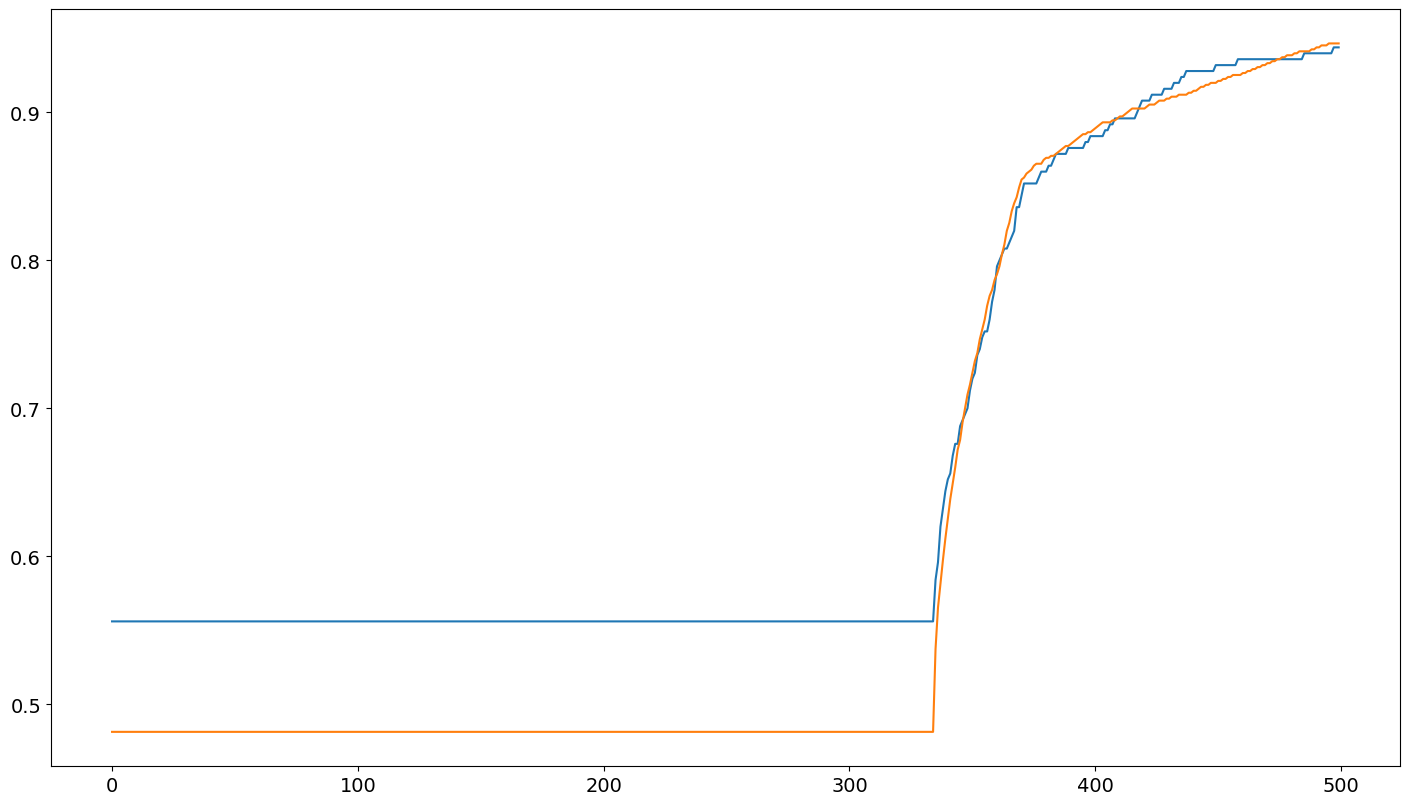

In [16]:
Y_pred = nn.predict(X_test_scaled)
print(nn.accuracy_score(Y_test, Y_pred))
print(Y_pred.shape)
plt.figure()
plt.plot(np.arange(nn.epochs),nn.accuracy_each_epoch_test,label='test')
plt.plot(np.arange(nn.epochs),nn.accuracy_each_epoch_train,label='train')

In [30]:
etas = np.logspace(-7,-3,5)
lmbds = np.logspace(-7,-3,5)
many_nns = np.zeros((len(etas),len(lmbds)),dtype=object)

for i,eta in enumerate(etas):
    for j,lmbd in enumerate(lmbds):
        nn = NeuralNetwork( X_train_scaled,Y_train.reshape(-1,1),n_hidden_neurons=2,n_categories=2,epochs=500,batch_size=4,
                    eta=eta,
                    lmbd=lmbd)
        nn.train()
        many_nns[i,j] = nn


100%|██████████| 500/500 [00:15<00:00, 33.04it/s]


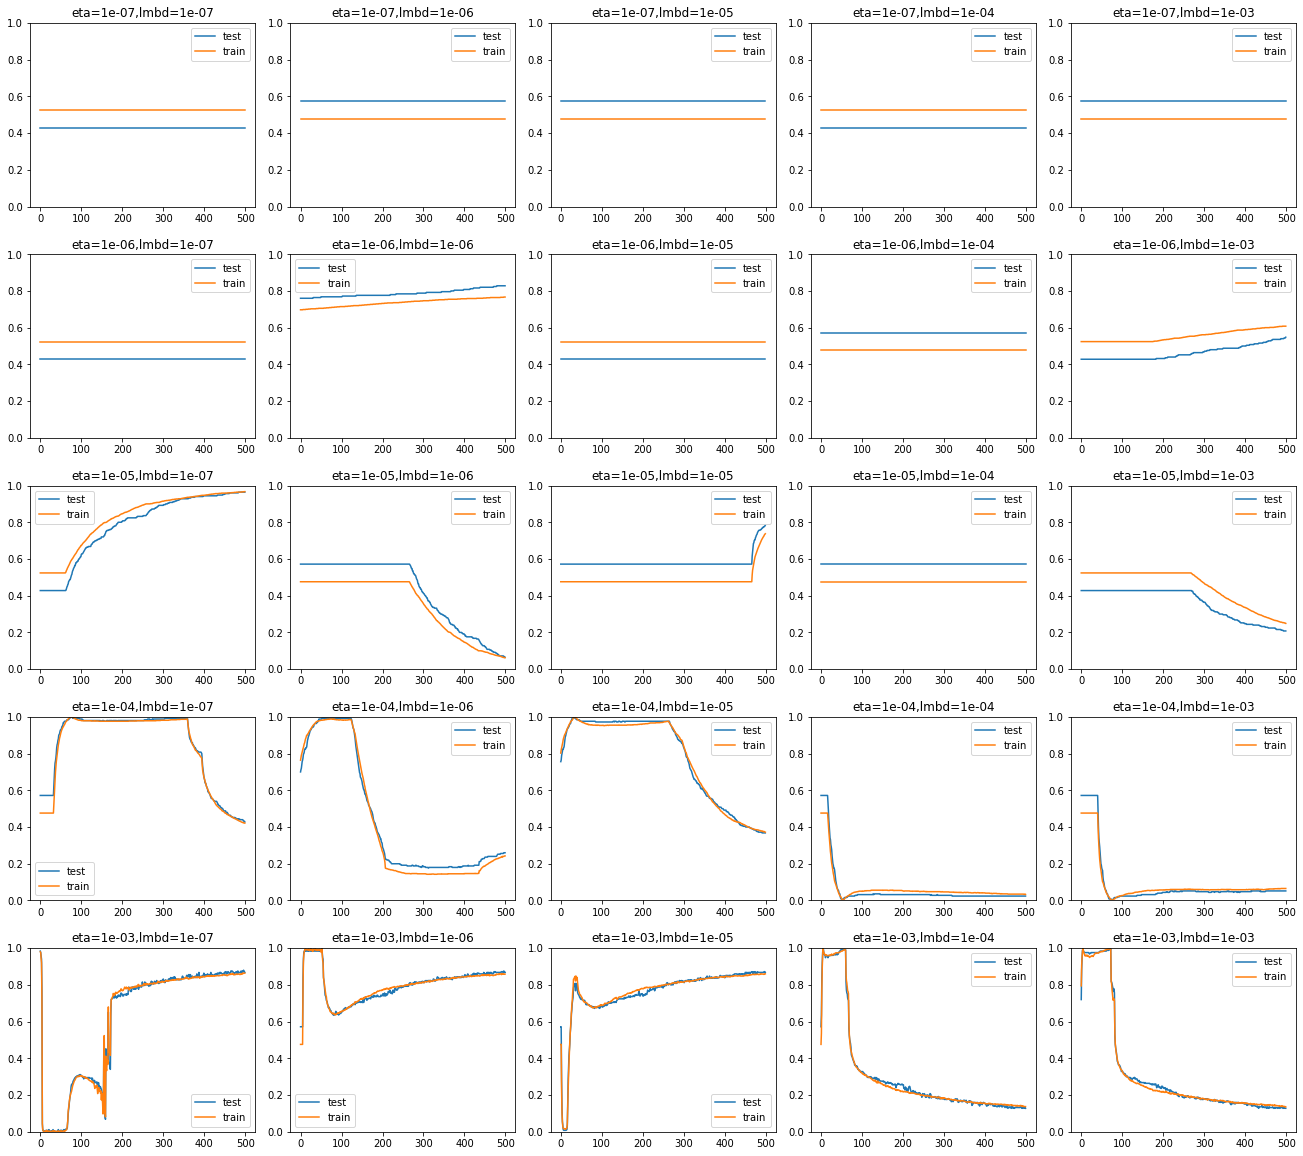

In [31]:
fig,ax = plt.subplots(5,5,figsize=(18,16))
epochs_arr = np.arange(nn.epochs)
for i,eta in enumerate(etas):
    for j,lmbd in enumerate(lmbds):
        ax[i,j].plot(epochs_arr,many_nns[i,j].accuracy_each_epoch_test,label='test')
        ax[i,j].plot(epochs_arr,many_nns[i,j].accuracy_each_epoch_train,label='train')
        ax[i,j].legend()
        ax[i,j].set_title('eta={:.0e},lmbd={:.0e}'.format(eta,lmbd))
        ax[i,j].set_ylim(0,1)
plt.savefig('./../figs/testing_accuracy_eta_lambda.pdf')

In [32]:
print(Y_pred)
np.sum(Y_pred > 0)

[0 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0
 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 1 1 0 1 1 1 1 0
 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0
 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0
 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0
 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1]


116

In [33]:
Y_pred_train = nn.predict(X_train_scaled)
accuracy_score(Y_train, Y_pred_train)

0.136

In [34]:
np.sum(Y_pred_train > 0)

389

In [35]:
etas = np.logspace(-7,1,9)
many_nns_only_eta = np.zeros(len(etas),dtype=object)

for i,eta in enumerate(etas):
    nn = NeuralNetwork( X_train_scaled,Y_train.reshape(-1,1),n_hidden_neurons=2,n_categories=2,epochs=500,batch_size=4,
                eta=eta,
                lmbd=0)
    nn.train()
    many_nns_only_eta[i] = nn


 43%|████▎     | 215/500 [00:06<00:08, 34.80it/s]/Users/jakobs/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/jakobs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in exp
/Users/jakobs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 500/500 [00:14<00:00, 34.22it/s]


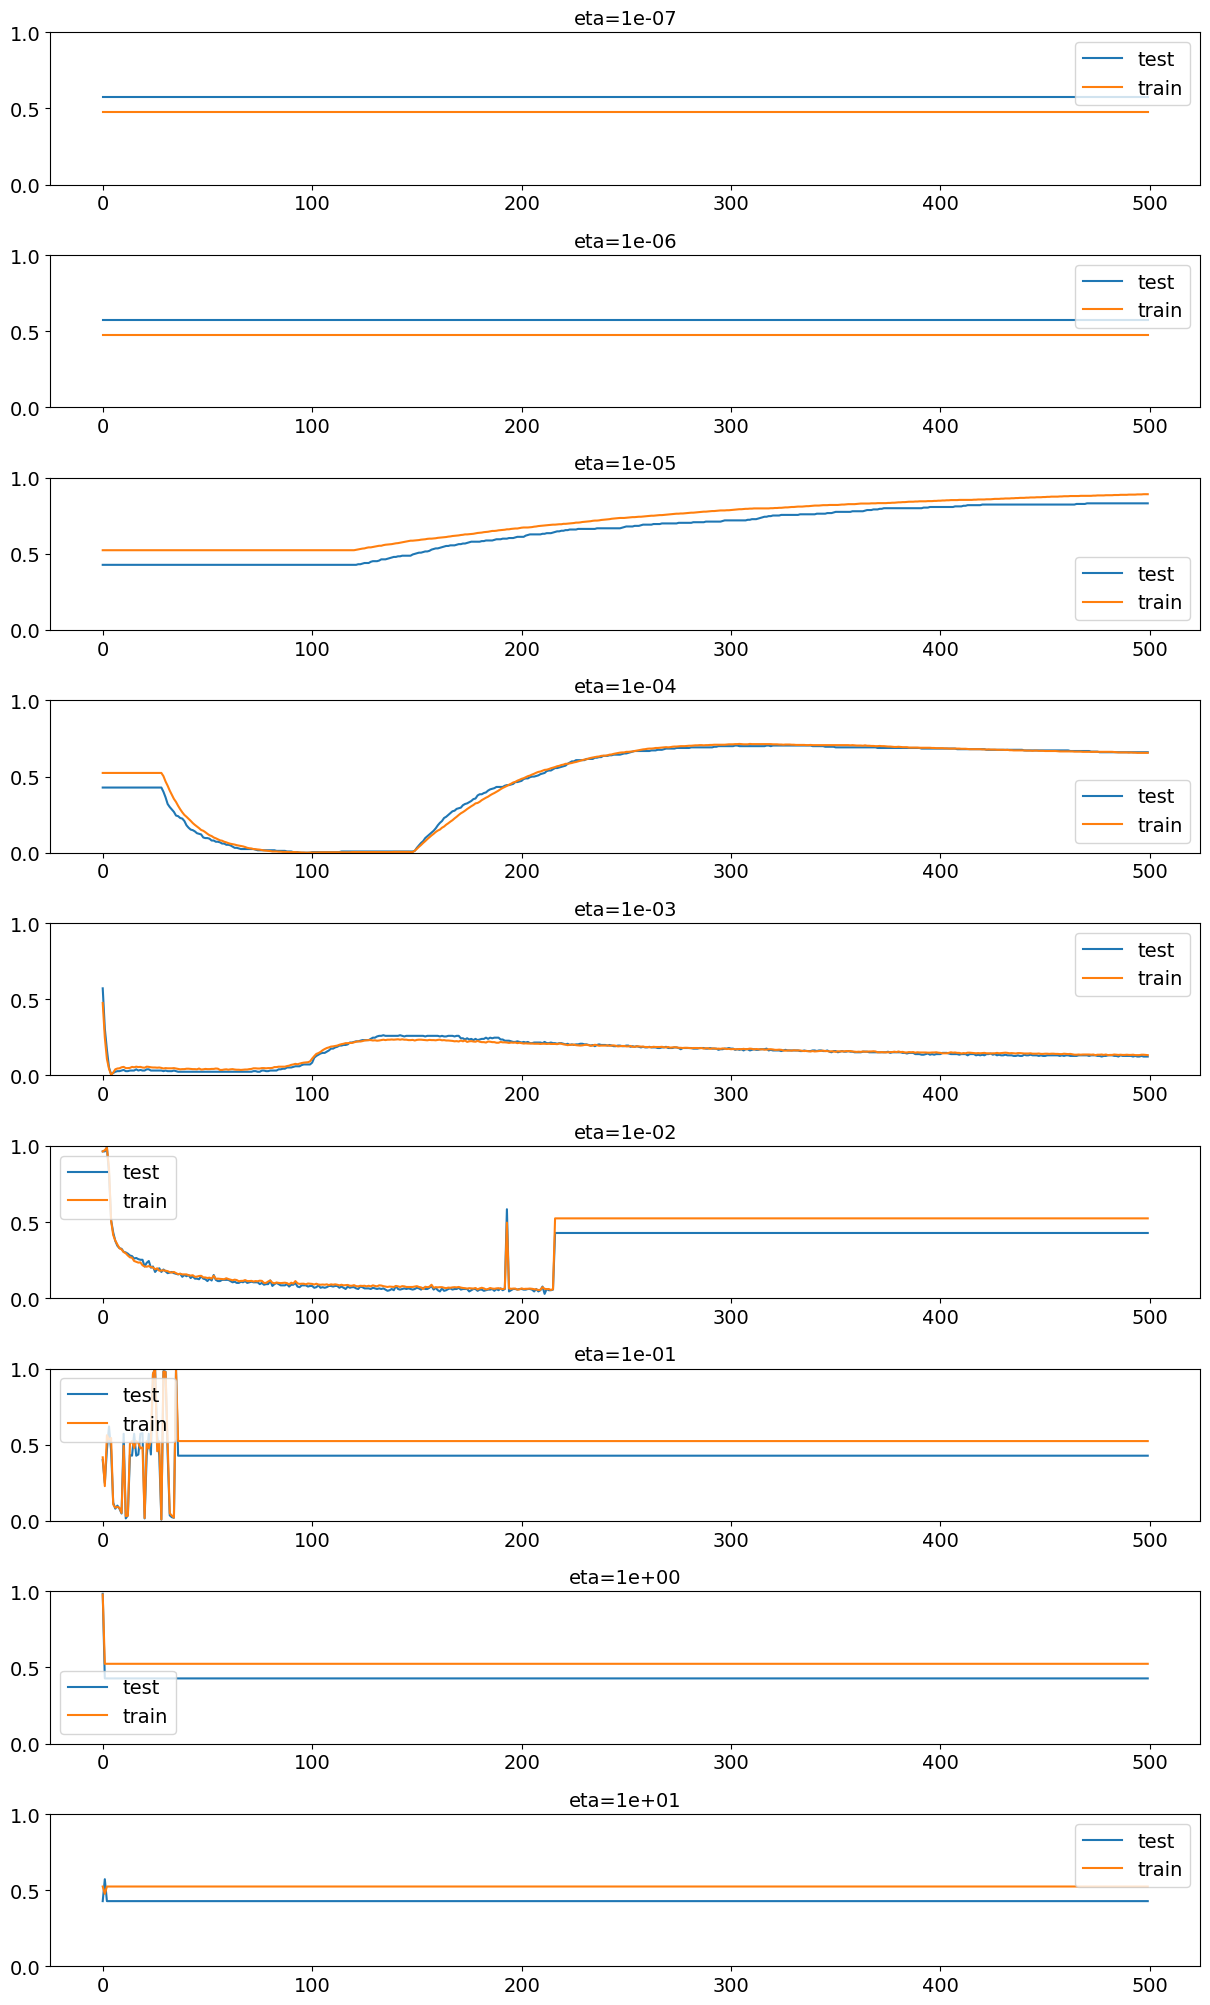

In [46]:
fig,ax = plt.subplots(len(etas),figsize=(12,20))
epochs_arr = np.arange(nn.epochs)
for i,eta in enumerate(etas):
    ax[i].plot(epochs_arr,many_nns_only_eta[i].accuracy_each_epoch_test,label='test')
    ax[i].plot(epochs_arr,many_nns_only_eta[i].accuracy_each_epoch_train,label='train')
    ax[i].legend()
    ax[i].set_title('eta={:.0e}'.format(eta,lmbd),fontsize=14)
    ax[i].set_ylim(0,1)

In [10]:
etas = np.logspace(-7,-1,9)
many_nns_only_eta_long = np.zeros(len(etas),dtype=object)

for i,eta in enumerate(etas):
    nn = NeuralNetwork( X_train_scaled,Y_train.reshape(-1,1),n_hidden_neurons=2,n_categories=2,epochs=1000,batch_size=4,
                eta=eta,
                lmbd=0)
    nn.train()
    many_nns_only_eta_long[i] = nn


 20%|█▉        | 196/1000 [00:05<00:23, 34.47it/s]/Users/jakobs/miniconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/jakobs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in exp
/Users/jakobs/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 1000/1000 [00:29<00:00, 33.64it/s]


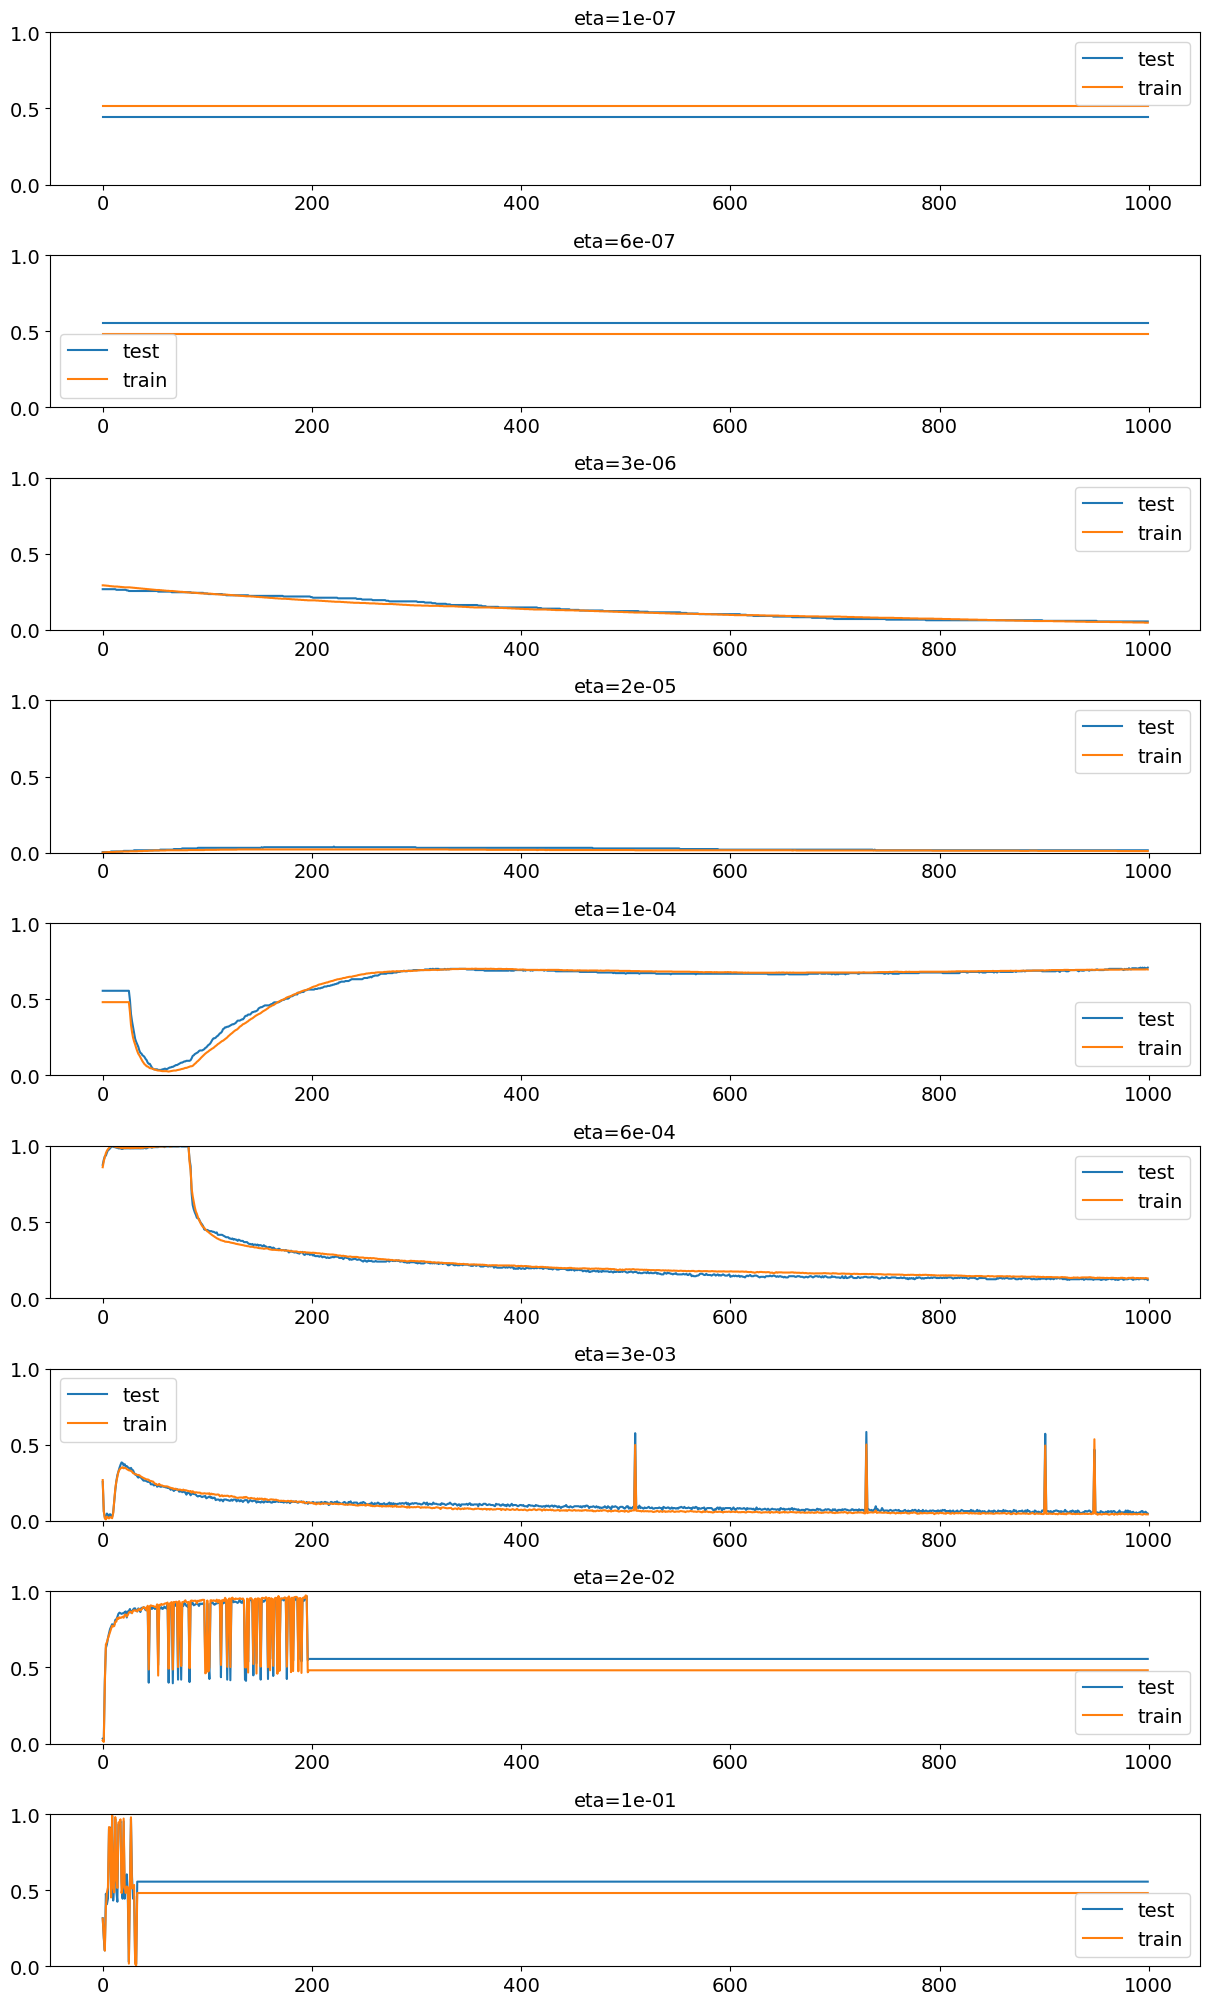

In [12]:
fig,ax = plt.subplots(len(etas),figsize=(12,20))
epochs_arr = np.arange(nn.epochs)
for i,eta in enumerate(etas):
    ax[i].plot(epochs_arr,many_nns_only_eta_long[i].accuracy_each_epoch_test,label='test')
    ax[i].plot(epochs_arr,many_nns_only_eta_long[i].accuracy_each_epoch_train,label='train')
    ax[i].legend()
    ax[i].set_title('eta={:.0e}'.format(eta),fontsize=14)
    ax[i].set_ylim(0,1)